In [15]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import torchvision.utils as vutils
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as agrad
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import PCA
%matplotlib inline

Create fully connected and convolutional autoencoders and image reconstructions

In [16]:
def plot_images(batch, rows, cols, title = ""):
    plt.figure(figsize = (rows, cols))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(
        vutils.make_grid(batch[:(rows * cols)], nrow = rows, normalize = True).cpu(),
        (1, 2, 0)))

cpu


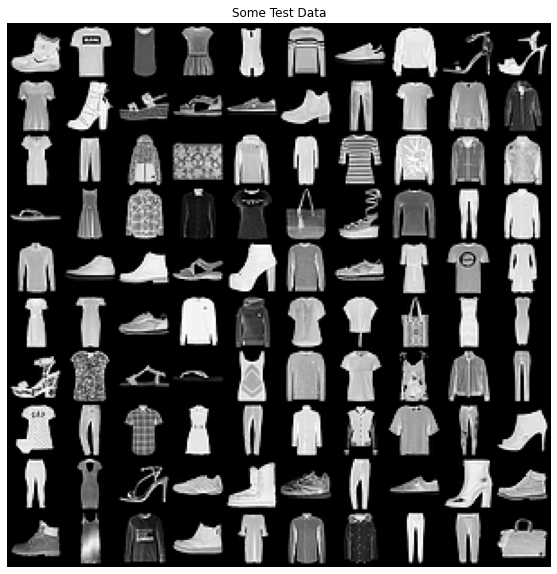

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

batch_size = 100
width = 28
height = 28
input_size = width * height

# Transforms images to a PyTorch Tensor
# Download the MNIST Dataset
train_data = FashionMNIST("./data", train = True, download = True, transform=transforms.ToTensor())
# DataLoader is used to load the dataset 
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
#first_batch = next(iter(train_loader))
#plot_images(first_batch[0], 10, 10, "Some Training Data")

augment_transform = transforms.Compose([transforms.RandomAffine(degrees = 20, translate = (0.2, 0.2),
                                                                interpolation = transforms.InterpolationMode.BILINEAR), transforms.ToTensor()])

aug_train_data = FashionMNIST("./data", train = True, download = True, transform=augment_transform)
aug_train_loader = DataLoader(aug_train_data, batch_size = batch_size, shuffle = True)
# first_batch = next(iter(aug_train_loader))
# plot_images(first_batch[0], 10, 10, "Some Augmented Training Data")

test_data = FashionMNIST("./data", download = True, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size = batch_size)
    #test_loader size 600, has 600 batches of images
#for ii, (images, labels) in enumerate(test_loader):
    #ii tracks the iteration we are on (0-599)
    #images is a tensor of length 100--100 images
        #images[0] has length of 1: contains a 28 by 28 matrix representing the image
    #labels is a tensor of length 100--the actual value of each image

first_batch = next(iter(test_loader)) #this is a batch of 100 images
plot_images(first_batch[0], 10, 10, "Some Test Data")

In [18]:
class FullyConnectedAutoencoder(nn.Module):
    def __init__(self, out_size):
        super(FullyConnectedAutoencoder, self).__init__()
        self.elayer1 = nn.Linear(input_size, 256)
        self.ebatch1 = nn.BatchNorm1d(256)
        self.elayer2 = nn.Linear(256, 128)
        self.ebatch2 = nn.BatchNorm1d(128)
        self.elayer3 = nn.Linear(128, out_size)

        self.dlayer1 = nn.Linear(out_size, 128)
        self.dbatch1 = nn.BatchNorm1d(128)
        self.dlayer2 = nn.Linear(128, 256)
        self.dbatch2 = nn.BatchNorm1d(256)
        self.dlayer3 = nn.Linear(256, input_size)
    
    def encoder(self, x):
        y1 = F.elu(self.ebatch1(self.elayer1(x)))
        y2 = F.elu(self.ebatch2(self.elayer2(y1)))
        z = F.elu(self.elayer3(y2))
        return z

    def decoder(self, z):
        y1 = F.elu(self.dbatch1(self.dlayer1(z)))
        y2 = F.elu(self.dbatch2(self.dlayer2(y1)))
        x = torch.sigmoid(self.dlayer3(y2))
        return x
        
    def forward(self, x):
        x = x.view(-1, input_size)
        z = self.encoder(x)
        y = self.decoder(z)
        y = y.view(-1, 1, width, height)
        return y

In [19]:
class ConvolutionalAutoencoder(nn.Module):
    def __init__(self, out_size):
        super(ConvolutionalAutoencoder, self).__init__()
        self.econv1 = nn.Conv2d(1, 32, kernel_size = 5, bias = False)
            #https://stats.stackexchange.com/questions/296679/what-does-kernel-size-mean
        self.ebatch1 = nn.BatchNorm2d(32)
        self.econv2 = nn.Conv2d(32, 8, kernel_size = 5, bias = False)
        self.ebatch2 = nn.BatchNorm2d(8)
        self.econv3 = nn.Conv2d(8, out_size, kernel_size = 20, bias = True)

        self.dconv1 = nn.ConvTranspose2d(out_size, 8, kernel_size = 20, bias = True)
        self.dbatch1 = nn.BatchNorm2d(8)
        self.dconv2 = nn.ConvTranspose2d(8, 32, kernel_size = 5, bias = False)
        self.dbatch2 = nn.BatchNorm2d(32)
        self.dconv3 = nn.ConvTranspose2d(32, 1, kernel_size = 5, bias = False)

    def encoder(self, x):
        y1 = F.elu(self.ebatch1(self.econv1(x)))
        #print(y1.size()) #print statements to see dimension
        y2 = F.elu(self.ebatch2(self.econv2(y1)))
        #print(y2.size())
        z = F.elu(self.econv3(y2))
        #print(z.size())
        return z

    def decoder(self, z):
        y1 = F.elu(self.dbatch1(self.dconv1(z)))
        #print(y1.size())
        y2 = F.elu(self.dbatch2(self.dconv2(y1)))
        #print(y2.size())
        x = torch.sigmoid(self.dconv3(y2))
        #print(x.size())
        return x
     
    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        return y

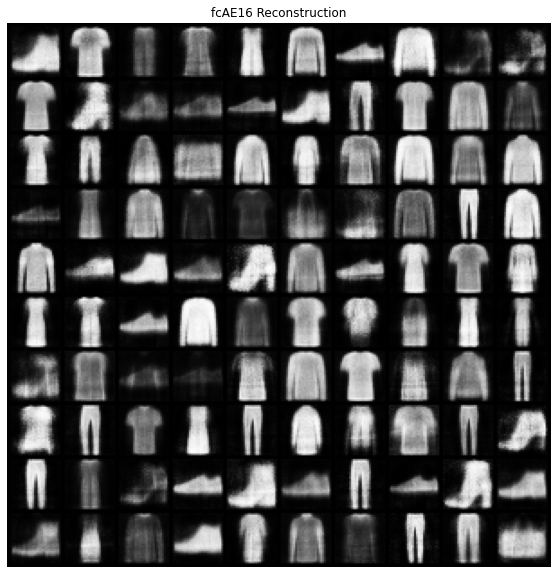

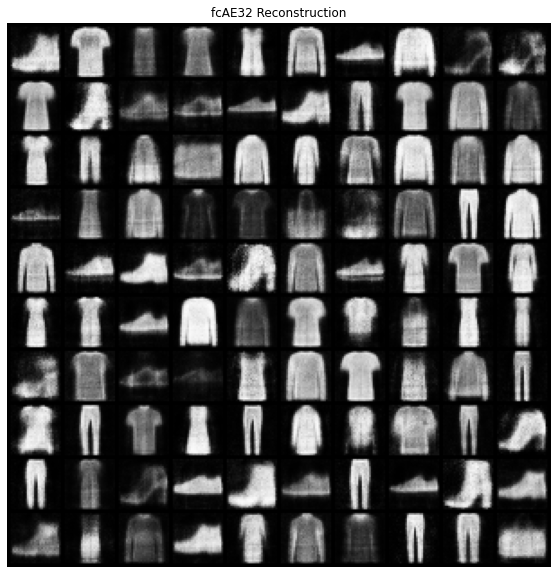

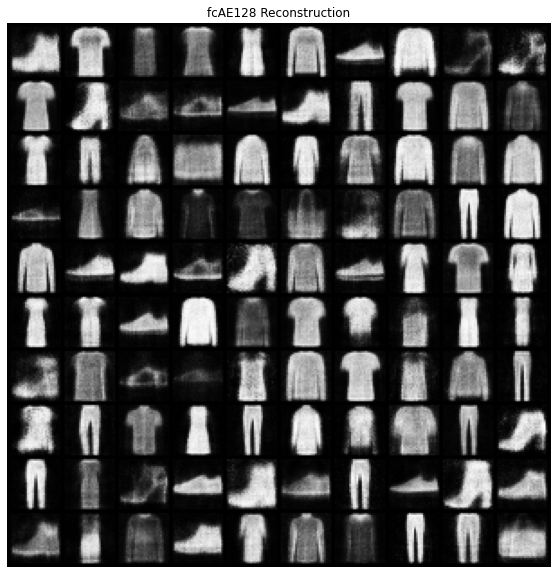

In [20]:
test_sample = first_batch[0]
    #length of test_sample is 100
    #print(len(test_sample[0])) will print 1 b/c the 28 by 28 is wrapped in a tensor of length 1 (is this # channels?)
        #https://datascience.stackexchange.com/questions/64278/what-is-a-channel-in-a-cnn
#for i in test_sample:
    #print(i.size()) #torch.Size([1, 28, 28])
    #i = i.reshape(-1, 28*28)
        #print(i.size()) #torch.Size([1, 784])
    #recon = fcAE16(i)
        #print(recon.size()) #torch.Size([1, 1, 28, 28])
        #print(recon[0].size()) #torch.Size([1, 28, 28])

outputs = []
#torch.Size([100, 1, 28, 28])
fcAE16 = FullyConnectedAutoencoder(16)
fcAE16.load_state_dict(torch.load("AEmodels/fcAE16.pth", map_location = device))
#fcAE16.eval() #Put into test mode https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch
for i in test_sample:
    fcAE16.eval()
    i = i.reshape(-1, 28*28) #-1 means infer the remaining dimension
    recon = fcAE16(i)
    outputs.append(recon[0])
plot_images(outputs, 10, 10, "fcAE16 Reconstruction")

outputs = []
fcAE32 = FullyConnectedAutoencoder(32)
fcAE32.load_state_dict(torch.load("AEmodels/fcAE32.pth", map_location = device))
for i in test_sample:
    fcAE32.eval()
    i = i.reshape(-1, 28*28)
    recon = fcAE32(i)
    outputs.append(recon[0])
plot_images(outputs, 10, 10, "fcAE32 Reconstruction")

outputs = []
fcAE128 = FullyConnectedAutoencoder(128)
fcAE128.load_state_dict(torch.load("AEmodels/fcAE128.pth", map_location = device))
for i in test_sample:
    fcAE128.eval()
    i = i.reshape(-1, 28*28)
    recon = fcAE128(i)
    outputs.append(recon[0])
plot_images(outputs, 10, 10, "fcAE128 Reconstruction")


<All keys matched successfully>

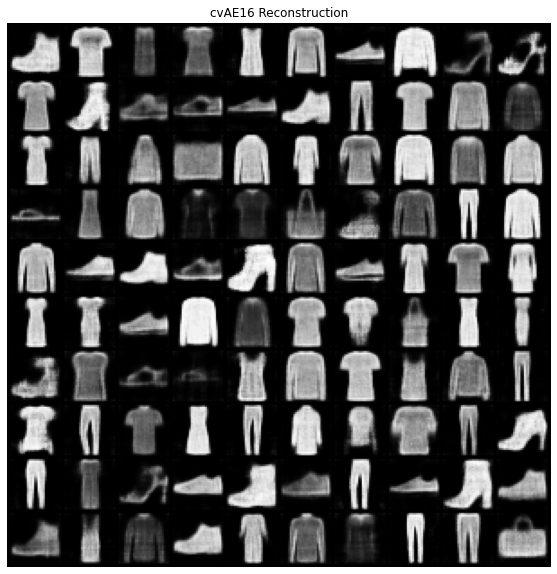

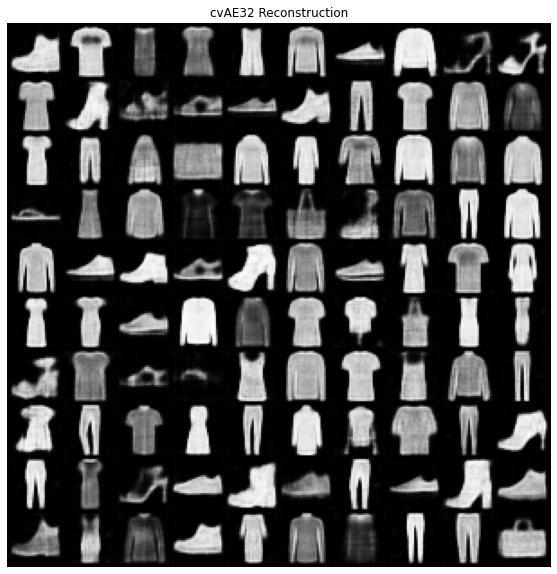

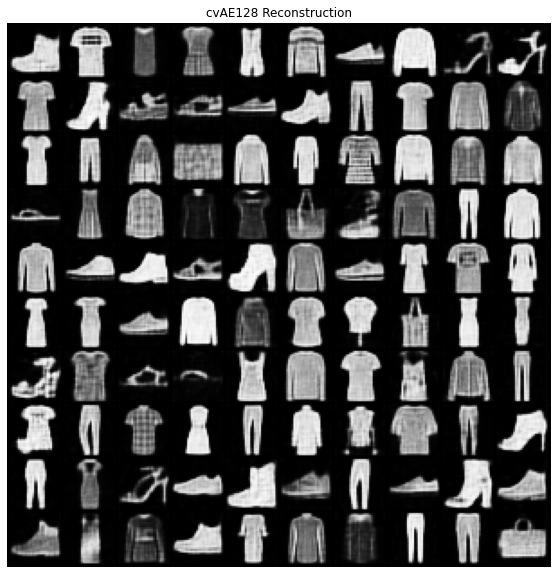

In [21]:
cvAE16 = ConvolutionalAutoencoder(16)
cvAE16.load_state_dict(torch.load("AEmodels/convAE16.pth", map_location = device))
#for i in test_sample:
    #cvAE16.eval()
    #i = i.reshape(-1, 28*28)
    #recon = cvAE16(i)
    #outputs.append(recon[0])
recon = cvAE16(test_sample) #don't need to resize, conv takes input of shape: [batch_size, #channels, width, height]
plot_images(recon, 10, 10, "cvAE16 Reconstruction")

cvAE32 = ConvolutionalAutoencoder(32)
cvAE32.load_state_dict(torch.load("AEmodels/convAE32.pth", map_location = device))
recon = cvAE32(test_sample)
plot_images(recon, 10, 10, "cvAE32 Reconstruction")

cvAE128 = ConvolutionalAutoencoder(128)
cvAE128.load_state_dict(torch.load("AEmodels/convAE128.pth", map_location = device))
recon = cvAE128(test_sample)
    #prints torch.Size([100, 32, 24, 24])
            #torch.Size([100, 8, 20, 20])
            #torch.Size([100, 128, 1, 1])
plot_images(recon, 10, 10, "cvAE128 Reconstruction")

cvAE32_aug = ConvolutionalAutoencoder(32)
cvAE32_aug.load_state_dict(torch.load("AEmodels/convAE32_aug.pth", map_location = device))

Between the fully connected and convolutional models, the images that are reconstructed using the convolutional models are clearer and more similar to the original models than the images that are reconstructed with the fully connected models, capturing more detail of the clothings. However, for both models, the images become more clear and detailed as the code dimension increases.

Compute a PCA of the training images

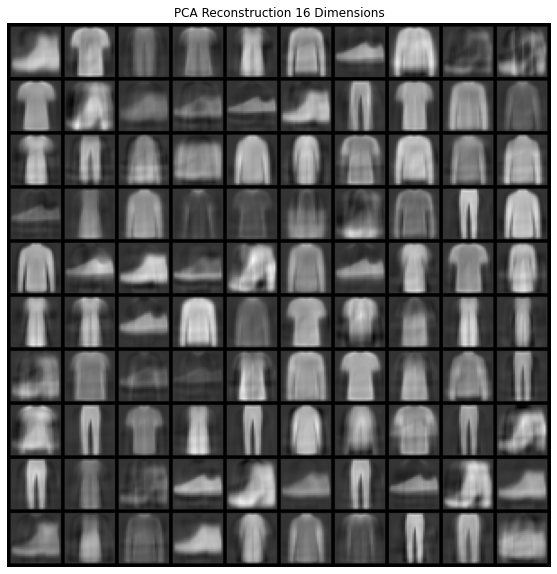

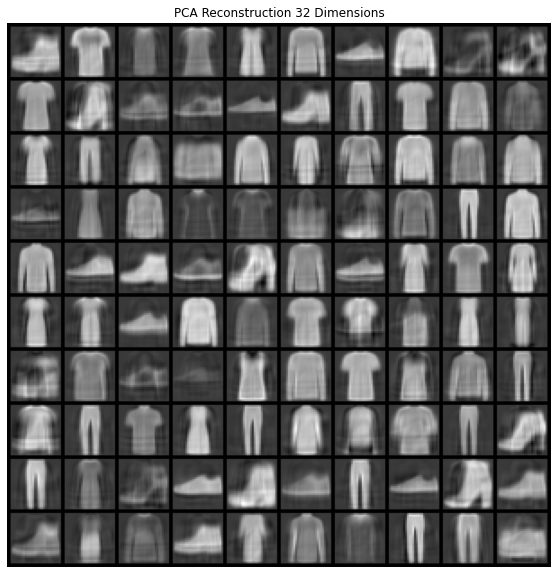

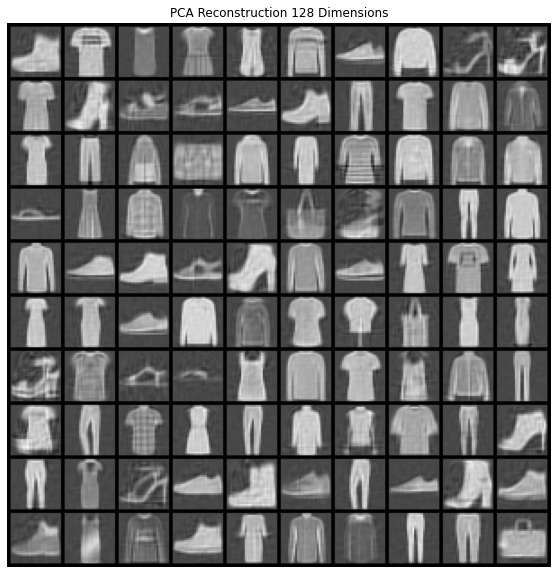

In [22]:
#load training data into input_mat
input_mat = []
for i, (images, labels) in enumerate(train_loader):
    for img in images:
        input_mat.append(img[0].reshape(28*28).numpy()) #reshape to 1D vector
test_mat = []
for s in test_sample:
    test_mat.append(s.reshape(28*28).numpy()) #reshape to 1D vector
#input_mat = torch.stack(input_mat)
    #print(input_mat.size()) #torch.Size([100, 784])
#U, S, V_16 = torch.pca_lowrank(input_mat, q=16)
    #print(V_16.size()) #torch.Size([784, 16])
#recon = torch.matmul(input_mat, V_16[:, :16])
    #print(recon.size()) #torch.Size([100, 16])
pca16 = PCA(n_components=16)
pca16.fit(input_mat)
reduced16 = pca16.transform(test_mat) 
    #print(len(reduced16)) = 100
    #print(len(reduced16[0])) = 16
recon = pca16.inverse_transform(reduced16)
    #print(len(recon)) = 100
    #print(len(recon[0])) = 784
to_plot = []
for r in recon:
    to_plot.append(torch.tensor(r.reshape(-1, 28, 28)))
plot_images(to_plot, 10, 10, "PCA Reconstruction 16 Dimensions")

pca32 = PCA(n_components=32)
pca32.fit(input_mat)
reduced32 = pca32.transform(test_mat) 
recon = pca32.inverse_transform(reduced32)
to_plot = []
for r in recon:
    to_plot.append(torch.tensor(r.reshape(-1, 28, 28)))
plot_images(to_plot, 10, 10, "PCA Reconstruction 32 Dimensions")

pca128 = PCA(n_components=128)
pca128.fit(input_mat)
reduced128 = pca128.transform(test_mat) 
recon = pca128.inverse_transform(reduced128)
to_plot = []
for r in recon:
    to_plot.append(torch.tensor(r.reshape(-1, 28, 28)))
plot_images(to_plot, 10, 10, "PCA Reconstruction 128 Dimensions")

Overall, the images constructed through PCA are not as clear or accurate as the images constructed through the autoencoders. This suggests that there was more data lost in the reconstruction process that may be due to the possiblity of the data not lying on a linear subspace.

For each AE, plot a sequence of images that are interpolated in the latent code space, followed by application of the decoder.

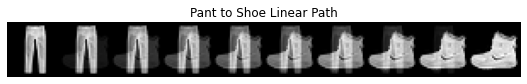

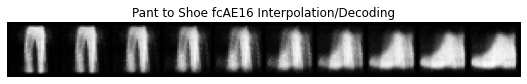

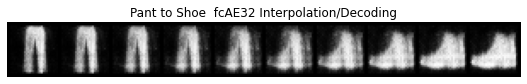

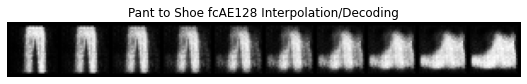

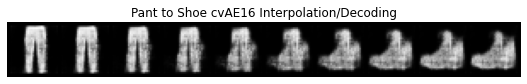

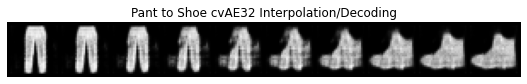

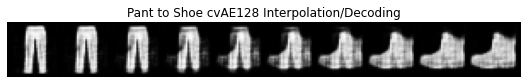

In [23]:
pant = (test_sample[16].reshape(-1, 28*28))
shoe = (test_sample[0].reshape(-1, 28*28))
ratios = np.linspace(0, 1, num=10)
images = []
for r in ratios:
    i = (1.0 - r) * pant + r * shoe
    images.append(i.reshape(-1, 28, 28))
plot_images(images, 10, 1, "Pant to Shoe Linear Path")

pant = fcAE16.encoder(test_sample[16].reshape(-1, 28*28))
shoe = fcAE16.encoder(test_sample[0].reshape(-1, 28*28))
ratios = np.linspace(0, 1, num=10)
encoded_images = []
for r in ratios:
    i = (1.0 - r) * pant + r * shoe
    encoded_images.append(i)
decoded_images = []
for ei in encoded_images:
    dec = fcAE16.decoder(ei).reshape(-1, 28, 28)
    decoded_images.append(dec)
plot_images(decoded_images, 10, 1, "Pant to Shoe fcAE16 Interpolation/Decoding")

pant = fcAE32.encoder(test_sample[16].reshape(-1, 28*28))
shoe = fcAE32.encoder(test_sample[0].reshape(-1, 28*28))
ratios = np.linspace(0, 1, num=10)
encoded_images = []
for r in ratios:
    i = (1.0 - r) * pant + r * shoe
    encoded_images.append(i)
decoded_images = []
for ei in encoded_images:
    dec = fcAE32.decoder(ei).reshape(-1, 28, 28)
    decoded_images.append(dec)
plot_images(decoded_images, 10, 1, "Pant to Shoe  fcAE32 Interpolation/Decoding")

pant = fcAE128.encoder(test_sample[16].reshape(-1, 28*28))
shoe = fcAE128.encoder(test_sample[0].reshape(-1, 28*28))
ratios = np.linspace(0, 1, num=10)
encoded_images = []
for r in ratios:
    i = (1.0 - r) * pant + r * shoe
    encoded_images.append(i)
decoded_images = []
for ei in encoded_images:
    dec = fcAE128.decoder(ei).reshape(-1, 28, 28)
    decoded_images.append(dec)
plot_images(decoded_images, 10, 1, "Pant to Shoe fcAE128 Interpolation/Decoding")

pant = cvAE16.encoder(test_sample[16].reshape(-1, 1, 28, 28))
shoe = cvAE16.encoder(test_sample[0].reshape(-1, 1, 28, 28))
ratios = np.linspace(0, 1, num=10)
encoded_images = []
for r in ratios:
    i = (1.0 - r) * pant + r * shoe
    encoded_images.append(i)
decoded_images = []
for ei in encoded_images:
    dec = cvAE16.decoder(ei).reshape(-1, 28, 28)
    decoded_images.append(dec)
plot_images(decoded_images, 10, 1, "Pant to Shoe cvAE16 Interpolation/Decoding")

pant = cvAE32.encoder(test_sample[16].reshape(-1, 1, 28, 28))
shoe = cvAE32.encoder(test_sample[0].reshape(-1, 1, 28, 28))
ratios = np.linspace(0, 1, num=10)
encoded_images = []
for r in ratios:
    i = (1.0 - r) * pant + r * shoe
    encoded_images.append(i)
decoded_images = []
for ei in encoded_images:
    dec = cvAE32.decoder(ei).reshape(-1, 28, 28)
    decoded_images.append(dec)
plot_images(decoded_images, 10, 1, "Pant to Shoe cvAE32 Interpolation/Decoding")

pant = cvAE128.encoder(test_sample[16].reshape(-1, 1, 28, 28))
shoe = cvAE128.encoder(test_sample[0].reshape(-1, 1, 28, 28))
ratios = np.linspace(0, 1, num=10)
encoded_images = []
for r in ratios:
    i = (1.0 - r) * pant + r * shoe
    encoded_images.append(i)
decoded_images = []
for ei in encoded_images:
    dec = cvAE128.decoder(ei).reshape(-1, 28, 28)
    decoded_images.append(dec)
plot_images(decoded_images, 10, 1, "Pant to Shoe cvAE128 Interpolation/Decoding")

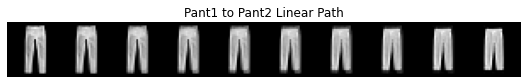

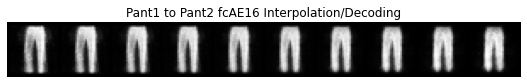

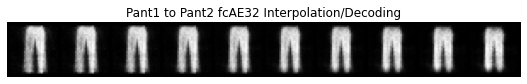

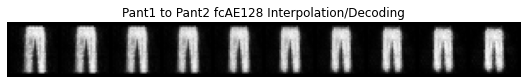

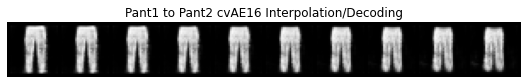

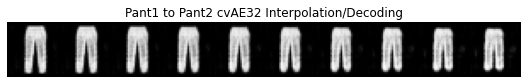

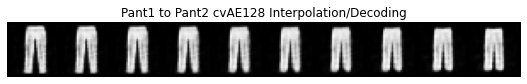

In [24]:
pant1 = (test_sample[16].reshape(-1, 28*28))
pant2 = (test_sample[21].reshape(-1, 28*28))
ratios = np.linspace(0, 1, num=10)
images = []
for r in ratios:
    i = (1.0 - r) * pant1 + r * pant2
    images.append(i.reshape(-1, 28, 28))
plot_images(images, 10, 1, "Pant1 to Pant2 Linear Path")

pant1 = fcAE16.encoder(test_sample[16].reshape(-1, 28*28))
pant2 = fcAE16.encoder(test_sample[21].reshape(-1, 28*28))
ratios = np.linspace(0, 1, num=10)
encoded_images = []
for r in ratios:
    i = (1.0 - r) * pant1 + r * pant2
    encoded_images.append(i)
decoded_images = []
for ei in encoded_images:
    dec = fcAE16.decoder(ei).reshape(-1, 28, 28)
    decoded_images.append(dec)
plot_images(decoded_images, 10, 1, "Pant1 to Pant2 fcAE16 Interpolation/Decoding")

pant1 = fcAE32.encoder(test_sample[16].reshape(-1, 28*28))
pant2 = fcAE32.encoder(test_sample[21].reshape(-1, 28*28))
ratios = np.linspace(0, 1, num=10)
encoded_images = []
for r in ratios:
    i = (1.0 - r) * pant1 + r * pant2
    encoded_images.append(i)
decoded_images = []
for ei in encoded_images:
    dec = fcAE32.decoder(ei).reshape(-1, 28, 28)
    decoded_images.append(dec)
plot_images(decoded_images, 10, 1, "Pant1 to Pant2 fcAE32 Interpolation/Decoding")

pant1 = fcAE128.encoder(test_sample[16].reshape(-1, 28*28))
pant2 = fcAE128.encoder(test_sample[21].reshape(-1, 28*28))
ratios = np.linspace(0, 1, num=10)
encoded_images = []
for r in ratios:
    i = (1.0 - r) * pant1 + r * pant2
    encoded_images.append(i)
decoded_images = []
for ei in encoded_images:
    dec = fcAE128.decoder(ei).reshape(-1, 28, 28)
    decoded_images.append(dec)
plot_images(decoded_images, 10, 1, "Pant1 to Pant2 fcAE128 Interpolation/Decoding")

pant1 = cvAE16.encoder(test_sample[16].reshape(-1, 1, 28, 28))
pant2 = cvAE16.encoder(test_sample[21].reshape(-1, 1, 28, 28))
ratios = np.linspace(0, 1, num=10)
encoded_images = []
for r in ratios:
    i = (1.0 - r) * pant1 + r * pant2
    encoded_images.append(i)
decoded_images = []
for ei in encoded_images:
    dec = cvAE16.decoder(ei).reshape(-1, 28, 28)
    decoded_images.append(dec)
plot_images(decoded_images, 10, 1, "Pant1 to Pant2 cvAE16 Interpolation/Decoding")

pant1 = cvAE32.encoder(test_sample[16].reshape(-1, 1, 28, 28))
pant2 = cvAE32.encoder(test_sample[21].reshape(-1, 1, 28, 28))
ratios = np.linspace(0, 1, num=10)
encoded_images = []
for r in ratios:
    i = (1.0 - r) * pant1 + r * pant2
    encoded_images.append(i)
decoded_images = []
for ei in encoded_images:
    dec = cvAE32.decoder(ei).reshape(-1, 28, 28)
    decoded_images.append(dec)
plot_images(decoded_images, 10, 1, "Pant1 to Pant2 cvAE32 Interpolation/Decoding")

pant1 = cvAE128.encoder(test_sample[16].reshape(-1, 1, 28, 28))
pant2 = cvAE128.encoder(test_sample[21].reshape(-1, 1, 28, 28))
ratios = np.linspace(0, 1, num=10)
encoded_images = []
for r in ratios:
    i = (1.0 - r) * pant1 + r * pant2
    encoded_images.append(i)
decoded_images = []
for ei in encoded_images:
    dec = cvAE128.decoder(ei).reshape(-1, 28, 28)
    decoded_images.append(dec)
plot_images(decoded_images, 10, 1, "Pant1 to Pant2 cvAE128 Interpolation/Decoding")

With all the interpolations, the transition from one image to the other appears to be smoother with the convolutional models than the fully connected models. Further, as the dimension of the latent space increases, we can observe the transition from the first image to the second image begins to happen more quickly. With the two images that are similar, there is essentially no observable "messy and ghostly" transition like there is with the transition between two different objects, as with the different objects there is a clear ghost like image of the second object that forms at the start of the transition.

Compute the Jacobian matrix of the decoder of a given model, taking as input the data point (image) at which to compute the Jacobian matrix. Compute the Jacobian of the decoder at a particular encoded data point for each model. Compute the SVD of the Jacobian.

In [31]:
def jacobian_mat(layer, input_):
    return agrad.functional.jacobian(layer, input_)

In [32]:
fcAE16dec = fcAE16.decoder
img = fcAE16.encoder(test_sample[0].reshape(-1, 28*28))
#print(img.size()) #torch.Size([1, 16])
fcAE16_jc = jacobian_mat(fcAE16dec, img)
#print(fcAE16_jc.size()) #torch.Size([1, 784, 1, 16]) this is effectively the number of output nodes x input nodes2
fcAE16_jc = fcAE16_jc.reshape(-1, 16)
#print(fcAE16_jc.size()) #torch.Size([784, 16])
u, s, vh = np.linalg.svd(fcAE16_jc)
#print(u.shape) #(784, 784)
#print(s.shape) #(16,)
#print(vh.shape) #(16, 16)
#print(s) # The singular values are the diagonal entries of the S matrix and are arranged in descending order. 16 SVs then full rank 
print("Max Singular Value for Fully Connected Autoencoder w/ Code Dimension 16: " + str(s[0]))
print("Min Singular Value for Fully Connected Autoencoder w/ Code Dimension 16: " + str(s[15]))
print("")

fcAE32dec = fcAE32.decoder
img = fcAE32.encoder(test_sample[0].reshape(-1, 28*28))
fcAE32_jc = jacobian_mat(fcAE32dec, img)
fcAE32_jc = fcAE32_jc.reshape(-1, 32)
u, s, vh = np.linalg.svd(fcAE32_jc)
#print(s)
print("Max Singular Value for Fully Connected Autoencoder w/ Code Dimension 32: " + str(s[0]))
print("Min Singular Value for Fully Connected Autoencoder w/ Code Dimension 32: " + str(s[31]))
print("")

fcAE128dec = fcAE128.decoder
img = fcAE128.encoder(test_sample[0].reshape(-1, 28*28))
fcAE128_jc = jacobian_mat(fcAE128dec, img)
fcAE128_jc = fcAE128_jc.reshape(-1, 128)
u, s, vh = np.linalg.svd(fcAE128_jc)
#print(s) 
print("Max Singular Value for Fully Connected Autoencoder w/ Code Dimension 128: " + str(s[0]))
print("Min Singular Value for Fully Connected Autoencoder w/ Code Dimension 128: " + str(s[127]))
print("")

cvAE16dec = cvAE16.decoder
img = cvAE16.encoder(test_sample[0].reshape(-1, 1, 28, 28))
#print(img.size()) #torch.Size([1, 16, 1, 1])
cvAE16_jc = jacobian_mat(cvAE16dec, img)
#print(cvAE16_jc.size()) #torch.Size([1, 1, 28, 28, 1, 16, 1, 1])
cvAE16_jc = cvAE16_jc.reshape(-1, 16)
u, s, vh = np.linalg.svd(cvAE16_jc)
#print(s) 
print("Max Singular Value for Convolutional Autoencoder w/ Code Dimension 16: " + str(s[0]))
print("Min Singular Value for Convolutional Autoencoder w/ Code Dimension 16: " + str(s[15]))
print("")

cvAE32dec = cvAE32.decoder
img = cvAE32.encoder(test_sample[0].reshape(-1, 1, 28, 28))
#print(img.size()) #torch.Size([1, 16, 1, 1])
cvAE32_jc = jacobian_mat(cvAE32dec, img)
#print(cvAE16_jc.size()) #torch.Size([1, 1, 28, 28, 1, 16, 1, 1])
cvAE32_jc = cvAE32_jc.reshape(-1, 32)
u, s, vh = np.linalg.svd(cvAE32_jc)
#print(s) 
print("Max Singular Value for Convolutional Autoencoder w/ Code Dimension 32: " + str(s[0]))
print("Min Singular Value for Convolutional Autoencoder w/ Code Dimension 32: " + str(s[31]))
print("")

cvAE128dec = cvAE128.decoder
img = cvAE128.encoder(test_sample[0].reshape(-1, 1, 28, 28))
#print(img.size()) #torch.Size([1, 16, 1, 1])
cvAE128_jc = jacobian_mat(cvAE128dec, img)
#print(cvAE16_jc.size()) #torch.Size([1, 1, 28, 28, 1, 16, 1, 1])
cvAE128_jc = cvAE128_jc.reshape(-1, 128)
u, s, vh = np.linalg.svd(cvAE128_jc)
#print(s) 
print("Max Singular Value for Convolutional Autoencoder w/ Code Dimension 128: " + str(s[0]))
print("Min Singular Value for Convolutional Autoencoder w/ Code Dimension 128: " + str(s[127]))
print("")

Max Singular Value for Fully Connected Autoencoder w/ Code Dimension 16: 7.2022595
Min Singular Value for Fully Connected Autoencoder w/ Code Dimension 16: 0.81735754

Max Singular Value for Fully Connected Autoencoder w/ Code Dimension 32: 4.9243193
Min Singular Value for Fully Connected Autoencoder w/ Code Dimension 32: 0.2572394

Max Singular Value for Fully Connected Autoencoder w/ Code Dimension 128: 3.2558637
Min Singular Value for Fully Connected Autoencoder w/ Code Dimension 128: 0.0005630833

Max Singular Value for Convolutional Autoencoder w/ Code Dimension 16: 2.2475228
Min Singular Value for Convolutional Autoencoder w/ Code Dimension 16: 0.000161768

Max Singular Value for Convolutional Autoencoder w/ Code Dimension 32: 2.3521688
Min Singular Value for Convolutional Autoencoder w/ Code Dimension 32: 0.00018895164

Max Singular Value for Convolutional Autoencoder w/ Code Dimension 128: 2.38734
Min Singular Value for Convolutional Autoencoder w/ Code Dimension 128: 9.650041e

For all of the models, the min singular value is greater than 1e-6, thus, suggesting that the Jacobians for all models are full rank if we use the threshold of 1e-6. This says the decoder is an immersion at this point for every model. However, if we used a threshold of 1e-5, then the Jacobian for the CAE128 model would not be full rank, and the decoder would not be an immersion.

For each model, plot the tangent vectors corresponding to the latent coordinate axes.

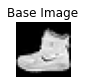

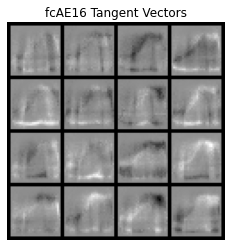

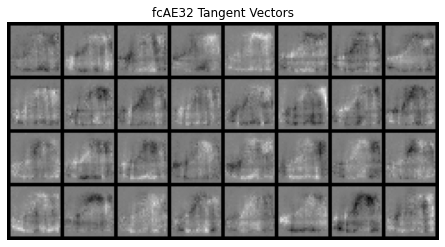

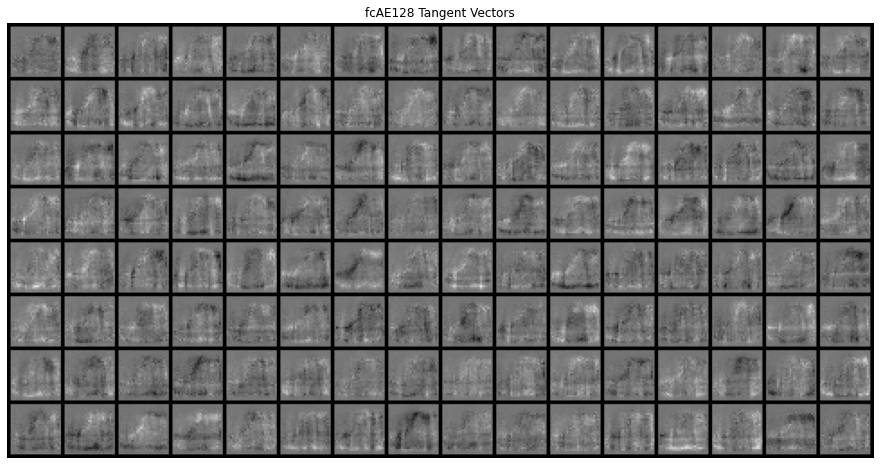

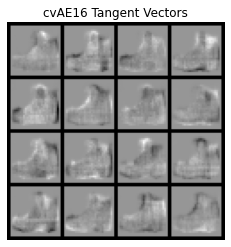

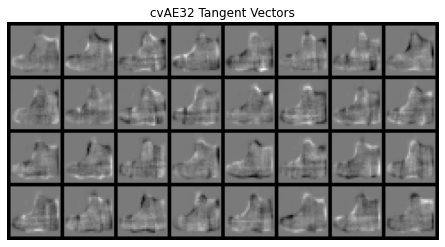

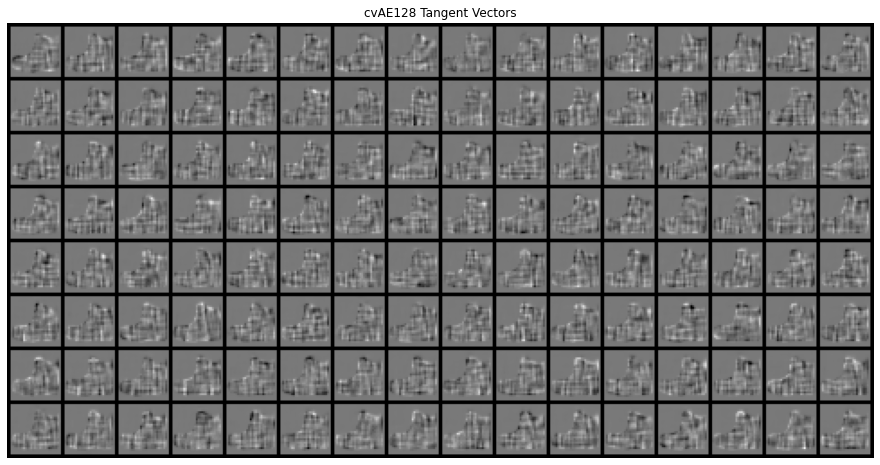

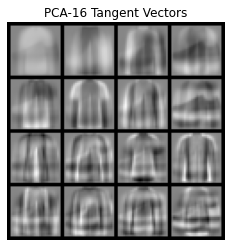

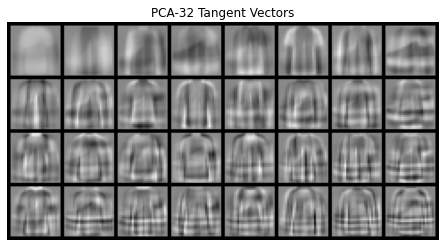

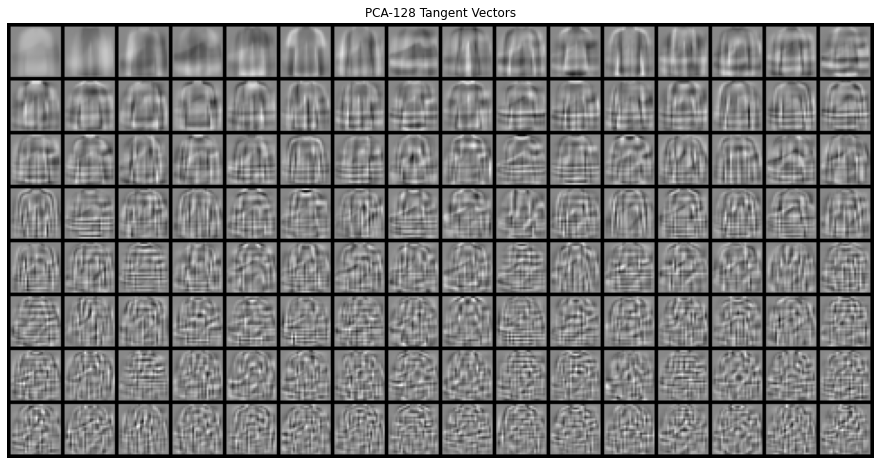

In [33]:
plot_images(test_sample[0], 1, 1, "Base Image")

tvs = []
for tv in fcAE16_jc.T: #for each tangent vector in the jacobian matrix
    tvs.append(tv.reshape(1, 28, 28))
plot_images(tvs, 4, 4, "fcAE16 Tangent Vectors")

tvs = []
for tv in fcAE32_jc.T: #for each tangent vector in the jacobian matrix
    tvs.append(tv.reshape(1, 28, 28))
plot_images(tvs, 8, 4, "fcAE32 Tangent Vectors")

tvs = []
for tv in fcAE128_jc.T: #for each tangent vector in the jacobian matrix
    tvs.append(tv.reshape(1, 28, 28))
plot_images(tvs, 16, 8, "fcAE128 Tangent Vectors")

tvs = []
for tv in cvAE16_jc.T: #for each tangent vector in the jacobian matrix
    tvs.append(tv.reshape(1, 28, 28))
plot_images(tvs, 4, 4, "cvAE16 Tangent Vectors")

tvs = []
for tv in cvAE32_jc.T: #for each tangent vector in the jacobian matrix
    tvs.append(tv.reshape(1, 28, 28))
plot_images(tvs, 8, 4, "cvAE32 Tangent Vectors")

tvs = []
for tv in cvAE128_jc.T: #for each tangent vector in the jacobian matrix
    tvs.append(tv.reshape(1, 28, 28))
plot_images(tvs, 16, 8, "cvAE128 Tangent Vectors")

#print(pca16.components_) #a 16 by 784 array... it is the eigenvectors...tangent vector in each dimension, same for all points
tvs = []
for tv in pca16.components_: #for each eigenvector
    tvs.append(torch.tensor(tv.reshape(1, 28, 28)))
plot_images(tvs, 4, 4, "PCA-16 Tangent Vectors")

tvs = []
for tv in pca32.components_: #for each eigenvector
    tvs.append(torch.tensor(tv.reshape(1, 28, 28)))
plot_images(tvs, 8, 4, "PCA-32 Tangent Vectors")

tvs = []
for tv in pca128.components_: #for each eigenvector
    tvs.append(torch.tensor(tv.reshape(1, 28, 28)))
plot_images(tvs, 16, 8, "PCA-128 Tangent Vectors")

In the tangent vectors above, we are essentially seeing the base image that has been altered a small amount along each of the latent dimensions. For all the autoencoder models, various brighter and darker edges are apparent for the all of the different tangent vectors, which makes sense as these are the changes along each latent dimension. For the PCA models, the changes along each dimension start to get very unclear in the model with code dimension 128. This also makes sense because our data manifold is likely not a linear subpsace, thus, PCA would not capture the dimensions particularly well.

For the same image, generate tangent vectors induced by x and y translation and rotation and compute the angles from these tangent vectors to the model's tangent space.

In [34]:
def compute_angles(img_dec, jacobian, model_type): #model_type is either 'autoencoder' or 'pca'
    rotated = transforms.functional.rotate(img_dec, angle=2.5)
    #plot_images(rotated, 1, 1, "Rotated")
    translate_x = transforms.functional.affine(img_dec, translate=(1,0), angle=0, scale=1.0, shear=0.0)
    #plot_images(translate_x, 1, 1, "TLS x")
    translate_y = transforms.functional.affine(img_dec, translate=(0,1), angle=0, scale=1.0, shear=0.0)
    #plot_images(translate_y, 1, 1, "TLS y")
    #print(img_dec)
    #print(rotated)
    d_rotated = torch.sub(rotated, img_dec) 
    d_rotated = torch.div(d_rotated, 2.5).reshape(28*28).detach().numpy() # have to divide by theta rotated
    d_translate_x = torch.sub(translate_x, img_dec).reshape(28*28).detach().numpy() #also have to divide by amount translated, but is 1 here
    d_translate_y = torch.sub(translate_y, img_dec).reshape(28*28).detach().numpy()
     #get the projection of tangent vector onto the tangent space (column space of jacobian), then compute the angle between tangent vec and the projection
    if model_type == 'autoencoder':
        q, r = np.linalg.qr(jacobian.numpy()) #need to convert to numpy because jacobian will be a tensor
        #print(q.shape)
    else: #then it will be PCA, which the "jacobian" is actually the eigenvectors, already numpy form
        q, r = np.linalg.qr(jacobian)
        #print(q.shape)
    proj_rotated = np.zeros(784) 
    proj_tlsx = np.zeros(784) 
    proj_tlsy = np.zeros(784) 
    for base in q.T:
        proj_rotated = np.add(proj_rotated, (np.dot(d_rotated, base)) * base)
        proj_tlsx = np.add(proj_tlsx, (np.dot(d_translate_x, base)) * base)
        proj_tlsy = np.add(proj_tlsy, (np.dot(d_translate_y, base)) * base)
    angle_rotated = np.arccos( (np.dot(proj_rotated, d_rotated)) / (np.linalg.norm(proj_rotated)*np.linalg.norm(d_rotated)) )
    angle_transx = np.arccos( (np.dot(proj_tlsx, d_translate_x)) / (np.linalg.norm(proj_tlsx)*np.linalg.norm(d_translate_x)) )
    angle_transy = np.arccos( (np.dot(proj_tlsy, d_translate_y)) / (np.linalg.norm(proj_tlsy)*np.linalg.norm(d_translate_y)) )
    return angle_rotated, angle_transx, angle_transy

In [36]:
#https://pytorch.org/vision/stable/generated/torchvision.transforms.functional.affine.html
#https://pytorch.org/vision/stable/generated/torchvision.transforms.functional.rotate.html

img_dec_fcAE16 = fcAE16.decoder(fcAE16.encoder(test_sample[0].reshape(-1, 28*28))).reshape(1, 28, 28)
#print(img_dec.size()) torch.Size([1, 28, 28])
#plot_images(img_dec, 1, 1, "Regular")
angle_rotated, angle_transx, angle_transy = compute_angles(img_dec_fcAE16, fcAE16_jc, 'autoencoder')
print("Angle between transformation tangent vector and the tangent space for Fully Connected Autoencoder with Code Dimension 16:")
print("Rotation: " + str(angle_rotated))
print("X Translation: " + str(angle_transx))
print("Y Translation: " + str(angle_transy))
print("")

img_dec_fcAE32 = fcAE32.decoder(fcAE32.encoder(test_sample[0].reshape(-1, 28*28))).reshape(1, 28, 28)
angle_rotated, angle_transx, angle_transy = compute_angles(img_dec_fcAE32, fcAE32_jc, 'autoencoder')
print("Angle between transformation tangent vector and the tangent space for Fully Connected Autoencoder with Code Dimension 32:")
print("Rotation: " + str(angle_rotated))
print("X Translation: " + str(angle_transx))
print("Y Translation: " + str(angle_transy))
print("")

img_dec_fcAE128 = fcAE128.decoder(fcAE128.encoder(test_sample[0].reshape(-1, 28*28))).reshape(1, 28, 28)
angle_rotated, angle_transx, angle_transy = compute_angles(img_dec_fcAE128, fcAE128_jc, 'autoencoder')
print("Angle between transformation tangent vector and the tangent space for Fully Connected Autoencoder with Code Dimension 128:")
print("Rotation: " + str(angle_rotated))
print("X Translation: " + str(angle_transx))
print("Y Translation: " + str(angle_transy))
print("")
               
img_dec_cvAE16 = cvAE16.decoder(cvAE16.encoder(test_sample[0].reshape(-1, 1, 28, 28))).reshape(1, 28, 28)
angle_rotated, angle_transx, angle_transy = compute_angles(img_dec_cvAE16, cvAE16_jc, 'autoencoder')
print("Angle between transformation tangent vector and the tangent space for Convolutional Autoencoder with Code Dimension 16:")
print("Rotation: " + str(angle_rotated))
print("X Translation: " + str(angle_transx))
print("Y Translation: " + str(angle_transy))
print("")

img_dec_cvAE32 = cvAE32.decoder(cvAE32.encoder(test_sample[0].reshape(-1, 1, 28, 28))).reshape(1, 28, 28)
angle_rotated, angle_transx, angle_transy = compute_angles(img_dec_cvAE32, cvAE32_jc, 'autoencoder')
print("Angle between transformation tangent vector and the tangent space for Convolutional Autoencoder with Code Dimension 32:")
print("Rotation: " + str(angle_rotated))
print("X Translation: " + str(angle_transx))
print("Y Translation: " + str(angle_transy))
print("")

img_dec_cvAE128 = cvAE128.decoder(cvAE128.encoder(test_sample[0].reshape(-1, 1, 28, 28))).reshape(1, 28, 28)
angle_rotated, angle_transx, angle_transy = compute_angles(img_dec_cvAE128, cvAE128_jc, 'autoencoder')
print("Angle between transformation tangent vector and the tangent space for Convolutional Autoencoder with Code Dimension 128:")
print("Rotation: " + str(angle_rotated))
print("X Translation: " + str(angle_transx))
print("Y Translation: " + str(angle_transy))
print("")

img_recon_pca16 = pca16.inverse_transform(pca16.transform(test_sample[0].reshape(1, 28*28).numpy()))
img_recon_pca16 = torch.from_numpy(img_recon_pca16)
img_recon_pca16 = img_recon_pca16.reshape(1, 28, 28)
angle_rotated, angle_transx, angle_transy = compute_angles(img_recon_pca16, pca16.components_.T, 'pca')
print("Angle between transformation tangent vector and the tangent space for PCA with Code Dimension 16:")
print("Rotation: " + str(angle_rotated))
print("X Translation: " + str(angle_transx))
print("Y Translation: " + str(angle_transy))
print("")

img_recon_pca32 = pca32.inverse_transform(pca32.transform(test_sample[0].reshape(1, 28*28).numpy()))
img_recon_pca32 = torch.from_numpy(img_recon_pca32)
img_recon_pca32 = img_recon_pca32.reshape(1, 28, 28)
angle_rotated, angle_transx, angle_transy = compute_angles(img_recon_pca32, pca32.components_.T, 'pca')
print("Angle between transformation tangent vector and the tangent space for PCA with Code Dimension 32:")
print("Rotation: " + str(angle_rotated))
print("X Translation: " + str(angle_transx))
print("Y Translation: " + str(angle_transy))
print("")

img_recon_pca128 = pca128.inverse_transform(pca128.transform(test_sample[0].reshape(1, 28*28).numpy()))
img_recon_pca128 = torch.from_numpy(img_recon_pca128)
img_recon_pca128 = img_recon_pca128.reshape(1, 28, 28)
angle_rotated, angle_transx, angle_transy = compute_angles(img_recon_pca128, pca128.components_.T, 'pca')
print("Angle between transformation tangent vector and the tangent space for PCA with Code Dimension 128:")
print("Rotation: " + str(angle_rotated))
print("X Translation: " + str(angle_transx))
print("Y Translation: " + str(angle_transy))
print("")

Angle between transformation tangent vector and the tangent space for Fully Connected Autoencoder with Code Dimension 16:
Rotation: 1.2240774345578695
X Translation: 1.0652128133132786
Y Translation: 0.4995615803043796

Angle between transformation tangent vector and the tangent space for Fully Connected Autoencoder with Code Dimension 32:
Rotation: 1.1568002247674973
X Translation: 0.9959550605412899
Y Translation: 0.5420570143347553

Angle between transformation tangent vector and the tangent space for Fully Connected Autoencoder with Code Dimension 128:
Rotation: 0.9230780263301607
X Translation: 0.8089143545002241
Y Translation: 0.4456953171433854

Angle between transformation tangent vector and the tangent space for Convolutional Autoencoder with Code Dimension 16:
Rotation: 1.0829250414389202
X Translation: 0.9861932458358438
Y Translation: 0.8445151690518229

Angle between transformation tangent vector and the tangent space for Convolutional Autoencoder with Code Dimension 32:
R

Same experiment as above but use model which was trained with data augmentation of randomly rotated and translated versions of the images.

In [64]:
cvAE32aug_dec = cvAE32_aug.decoder
img = cvAE32_aug.encoder(test_sample[0].reshape(-1, 1, 28, 28))
#print(img.size()) #torch.Size([1, 16, 1, 1])
cvAE32aug_jc = jacobian_mat(cvAE32aug_dec, img)
#print(cvAE16_jc.size()) #torch.Size([1, 1, 28, 28, 1, 16, 1, 1])
cvAE32aug_jc = cvAE32aug_jc.reshape(-1, 32)

img_dec_cvAE32aug = cvAE32_aug.decoder(cvAE32_aug.encoder(test_sample[0].reshape(-1, 1, 28, 28))).reshape(1, 28, 28)
angle_rotated, angle_transx, angle_transy = compute_angles(img_dec_cvAE32aug, cvAE32aug_jc, 'autoencoder')
print("Angle between transformation tangent vector and the tangent space for Convolutional Autoencoder trained with augmented data:")
print("Rotation: " + str(angle_rotated))
print("X Translation: " + str(angle_transx))
print("Y Translation: " + str(angle_transy))
print("")

Angle between transformation tangent vector and the tangent space for Convolutional Autoencoder trained with augmented data:
Rotation: 0.881864695862275
X Translation: 0.4479380445115333
Y Translation: 0.47717664093091444



Based on the tangent space measurements, data augmentation did help the model learn rotations and translations. The angles between the transformation tangent vectors and the tangent space are noticably lower with the augmented model than the non augmented model.